In [1]:
import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

import sys
sys.path.append("/Users/xiaoxuanj/work/work_allen/Ephys/code_library/ephys_code/")
sys.path.append("/Users/xiaoxuanj/work/work_allen/Ephys/code_library/ephys_code/dimensionality")

import data_loader as dl

import matrix_utils as mu

import psth_utils as pu

import TTP_utils as TTP_utils

In [2]:
from scipy.signal import find_peaks
def find_psth_peaks(x, prominence=1, width=20):
    peaks, properties = find_peaks(x, prominence=prominence, width=width)
    #print(properties["prominences"], properties["widths"])
    return peaks, properties

# plot for all mice grouped across trials (Paper)

In [ ]:
# select trials with number of spikes above threshold in a population
import glob
PSTH_bintime=1
cmap_max=2
smooth=3
RF_true=True
mouse_IDs = ['306046','388523', '389262',  '408153','410344', '415149', '412809', '412804',
             '416856', '419114',  '419117', '419118', '419119', '424445',
             '415148', '416356','416861','419112','419116']
WW2=[]
WW3=[]
HH2=[]
HH3=[]
TT2=[]
TT3=[]
FR2=[]
FR3=[]
N=0
for mouseID in mouse_IDs:

    # 1. load spikes
    basepath = '/Users/xiaoxuanj/work/work_allen/Ephys/mouse'+mouseID
    #basepath = nwbpath = '/Volumes/local1/work_allen/Ephys/mouse'+mouseID
    # spikes for preferred condition
    #spikes_pref = np.load(basepath+'/psth_pref_trial.npy')
    spikes_pref = dl.load_npz(basepath+'/matrix/drifting_grating_cortex.npz')
    #df_all = dl.data_loader(mouseID, datatype='units_cortex')[0]
    df_all = pd.read_csv(basepath+'/matrix/mouse'+mouseID+'_cortex_meta.csv')
    assert spikes_pref.shape[0]==len(df_all)
    
    # select trials for contrast
    if int(mouseID)>389262:
        stim_table = pd.read_csv(glob.glob('/Users/xiaoxuanj/work/work_allen/Ephys/mouse'+'412809'+'/matrix/'+'stim_table_drifting*.csv')[0])
        print(stim_table["b'Contrast'"].unique())
        select_trials = np.where(stim_table["b'Contrast'"]>0.5)[0]
        spikes_pref=spikes_pref[:,select_trials,:]
    print(spikes_pref.shape)
    

    if RF_true==True:
        # 2. select units CCG cluster and RF on screen
        df=pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/meta_cluster_RF/mouse'+mouseID+'_meta_cluster_RF.csv', index_col=0)
        labels=df.cluster.values
    else:
        df=pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/meta_cluster/mouse'+mouseID+'_meta_cluster.csv', index_col=0)
        # for all units, use old clustering id; for RF constrained, also use old
        f = '/Users/xiaoxuanj/work/work_allen/Ephys/mouse'+mouse_ID+'/CCG_diff_cluster_labels.npy'
        labels = np.load(f)
        df['cluster']=labels
    
    select_idx = []
    for idx, row in df_all.iterrows():
        probe_id=row['probe_id']
        unit_id=row['unit_id']
        if unit_id in df[df.probe_id==probe_id].unit_id.values:
            select_idx.append(idx)      

    spikes_pref = spikes_pref[select_idx, :, :]
    assert spikes_pref.shape[0]==len(df)
    

    # calculate PSTH for 1. all condition: spikes 2. preferred: spikes_pref
    unit_psth, time = pu.get_PSTH_alldim(spikes_pref, PSTH_bintime=PSTH_bintime)
    # convert to spk/sec
    unit_psth = unit_psth/(PSTH_bintime/1000.)

    unit_psth_mean=unit_psth.mean(1)
    unit_psth_mean.shape

    # scale to the same size
    plt.figure(figsize=(16,10))
    plt.subplot(331)
    tmp = unit_psth_mean[np.where(labels==1)[0],:]
    tmp_baseline=tmp[:,:int(400/PSTH_bintime)]-np.tile(tmp[:,:int(30/PSTH_bintime)].mean(1), (int(400/PSTH_bintime),1)).T
    tmp_baseline_norm=tmp_baseline/np.tile(np.max(tmp_baseline, axis=1), (tmp_baseline.shape[1],1)).T
    plt.imshow(tmp_baseline_norm,
               vmin=-cmap_max, vmax=cmap_max,
               cmap='bwr', 
               aspect='auto')

    x_label=np.arange(0,int(400/PSTH_bintime),20)*int(400/PSTH_bintime)
    plt.xticks(range(0,int(400/PSTH_bintime),20), x_label)
    plt.colorbar()
    plt.title('PSTH subtracted baseline (50ms) Cluster 1')
    plt.xlabel('Time (ms)')

    plt.subplot(334)
    plt.plot(gaussian_filter((tmp[:,:int(400/PSTH_bintime)]-np.tile(tmp[:,:int(50/PSTH_bintime)].mean(1), (int(400/PSTH_bintime),1)).T).mean(0),1))
    plt.xticks(range(0,int(400/PSTH_bintime),20), x_label)
    plt.ylim([-2, cmap_max*10])

    plt.subplot(332)
    tmp = unit_psth_mean[np.where(labels==2)[0],:]
    tmp_baseline=tmp[:,:int(400/PSTH_bintime)]-np.tile(tmp[:,:int(30/PSTH_bintime)].mean(1), (int(400/PSTH_bintime),1)).T
    tmp_baseline_norm=tmp_baseline/np.tile(np.max(tmp_baseline, axis=1), (tmp_baseline.shape[1],1)).T
    plt.imshow(tmp_baseline_norm,
               vmin=-cmap_max, vmax=cmap_max,
               cmap='bwr', 
               aspect='auto')
    x_label=np.arange(0,int(400/PSTH_bintime),20)*PSTH_bintime
    plt.xticks(range(0,int(400/PSTH_bintime),20), x_label)
    plt.title('Cluster 2')
    plt.xlabel('Time (ms)')

    plt.subplot(335)
    plt.plot(gaussian_filter((tmp[:,:int(400/PSTH_bintime)]-np.tile(tmp[:,:int(50/PSTH_bintime)].mean(1), (int(400/PSTH_bintime),1)).T).mean(0),1))
    plt.xticks(range(0,int(400/PSTH_bintime),20), x_label)
    plt.ylim([-2, cmap_max*10])

    plt.subplot(333)
    tmp = unit_psth_mean[np.where(labels==3)[0],:]
    tmp_baseline=tmp[:,:int(400/PSTH_bintime)]-np.tile(tmp[:,:int(30/PSTH_bintime)].mean(1), (int(400/PSTH_bintime),1)).T
    tmp_baseline_norm=tmp_baseline/np.tile(np.max(tmp_baseline, axis=1), (tmp_baseline.shape[1],1)).T
    plt.imshow(tmp_baseline_norm,
               vmin=-cmap_max, vmax=cmap_max,
               cmap='bwr', 
               aspect='auto') #len(np.where(labels==2)[0])/float(len(np.where(labels==3)[0]))
    x_label=np.arange(0,int(400/PSTH_bintime),20)*PSTH_bintime
    plt.xticks(range(0,int(400/PSTH_bintime),20), x_label)
    plt.title('Cluster 3')
    plt.xlabel('Time (ms)')

    plt.subplot(336)
    plt.plot(gaussian_filter((tmp[:,:int(400/PSTH_bintime)]-np.tile(tmp[:,:int(50/PSTH_bintime)].mean(1), (int(400/PSTH_bintime),1)).T).mean(0), 1))
    plt.xticks(range(0,int(400/PSTH_bintime),20), x_label)
    plt.ylim([-2, cmap_max*10])

    plt.tight_layout()
    #plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/PSTH/mouse'+mouseID+'_PSTH_baseline_subtracted_all.pdf')

    unit_psth2 = unit_psth[np.where(labels==2)[0],:,:100].mean(1)
    unit_psth3 = unit_psth[np.where(labels==3)[0],:,:100].mean(1)

    x2=gaussian_filter(unit_psth2.mean(0), smooth)
    peaks2, properties2=find_psth_peaks(x2, prominence=0.8, width=5)        
    x3=gaussian_filter(unit_psth3.mean(0), smooth)
    peaks3, properties3=find_psth_peaks(x3, prominence=0.8, width=5)
    if len(properties2["right_ips"]-properties2["left_ips"])>0:
        # select the peak with largest width and save
        idx = np.where((properties2["right_ips"]-properties2["left_ips"])==
                       max(properties2["right_ips"]-properties2["left_ips"]))[0]
        if len(idx)>1:
            idx=idx[0]
        W2 = (properties2["right_ips"]-properties2["left_ips"])[idx]
        H2 = (x2[peaks2])[idx]
        T2 = peaks2[idx]*PSTH_bintime
    if len(properties3["right_ips"]-properties3["left_ips"])>0:
        # select the peak with largest width and save
        idx = np.where((properties3["right_ips"]-properties3["left_ips"])==
                       max(properties3["right_ips"]-properties3["left_ips"]))[0]
        if len(idx)>1:
            idx=idx[0]
        W3 = (properties3["right_ips"]-properties3["left_ips"])[idx]
        H3 = (x3[peaks3])[idx]
        T3 = peaks3[idx]*PSTH_bintime

    #print(width2, width3)
    #print(height2, height3)

        plt.figure(figsize=(5,3))
        plt.plot(x2)
        plt.plot(peaks2, x2[peaks2], "x")
        plt.vlines(x=peaks2, ymin=x2[peaks2] - properties2["prominences"],
                   ymax = x2[peaks2], color = "C1")
        plt.hlines(y=properties2["width_heights"], xmin=properties2["left_ips"],
                   xmax=properties2["right_ips"], color = "C1")

        plt.plot(x3)
        plt.plot(peaks3, x3[peaks3], "x")
        plt.vlines(x=peaks3, ymin=x3[peaks3] - properties3["prominences"],
                   ymax = x3[peaks3], color = "C1")
        plt.hlines(y=properties3["width_heights"], xmin=properties3["left_ips"],
                   xmax=properties3["right_ips"], color = "C1")
        plt.xticks(np.arange(0, 101, 20), np.arange(0, 101, 20)*PSTH_bintime)
        plt.xlabel('Time (ms)')
        #plt.ylim([0,20])

        #plt.plot(spikes_select3[n,t,10*PSTH_bintime:100*PSTH_bintime]*1000)
        #plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/func_connect/cosyne/example_population_first_peak_1.pdf')
        #print(W2[t], H2[t], T2[t], W3[t], H3[t], T3[t])

    WW2.append(W2)
    WW3.append(W3)
    HH2.append(H2)
    HH3.append(H3)
    TT2.append(T2)
    TT3.append(T3)
    
with sns.axes_style("white"):
    g=sns.jointplot(x=WW2, y=WW3, color="k", xlim=[0,70], ylim=[0,70]);
#plt.xlabel('Peak width of cluster 2', fontsize=15)
#plt.ylabel('Peak width of cluster 3', fontsize=15)
g.ax_joint.collections[0].set_alpha(0.3)
lims = [max(0, 0), min(70, 70)]
g.ax_joint.plot(lims, lims, ':k')
g.set_axis_labels('First peak width (cluster 2)', 'First peak width (cluster 3)', fontsize=14)

#plt.title('Compactness of population response', fontsize=16)

with sns.axes_style("white"):
    g=sns.jointplot(x=HH2, y=HH3, color="k", xlim=[0,30], ylim=[0,30]);
g.ax_joint.collections[0].set_alpha(0.3)
#plt.xlabel('Peak height of cluster 2', fontsize=15)
#plt.ylabel('Peak height of cluster 3', fontsize=15)
lims = [max(0, 0), min(30, 30)]
g.ax_joint.plot(lims, lims, ':k') 
g.set_axis_labels('First peak height (cluster 2)', 'First peak height (cluster 3)', fontsize=14)

with sns.axes_style("white"):
    g=sns.jointplot(x=TT2, y=TT3,  color="k", xlim=[0,150], ylim=[0,150]);
g.ax_joint.collections[0].set_alpha(0.2)
#plt.xlabel('TTP of cluster 2', fontsize=15)
#plt.ylabel('TTP of cluster 3', fontsize=15)
lims = [max(0, 0), min(150, 150)]
g.ax_joint.plot(lims, lims, ':k') 
g.set_axis_labels('First peak time (cluster 2)', 'First peak time (cluster 3)', fontsize=14)


#plt.title('Compactness of population response', fontsize=16)

In [7]:
# statistics
from scipy.stats import ttest_ind
ttest_ind(WW3, WW2)

Ttest_indResult(statistic=array([-1.37013106]), pvalue=array([0.17913069]))

In [9]:
print(np.nanmean(WW2), np.nanstd(WW2)/np.sqrt(len((WW2))))
print(np.nanmean(WW3), np.nanstd(tmp)/np.sqrt(len((WW3))))

(22.059943628603225, 1.3530133032048175)
(30.280072114539447, 0.8936338839365703)


In [8]:
ttest_ind(TT3, TT2)

Ttest_indResult(statistic=array([7.70052568]), pvalue=array([4.04603181e-09]))

In [10]:
print(np.nanmean(TT2), np.nanstd(WW2)/np.sqrt(len((TT2))))
print(np.nanmean(TT3), np.nanstd(tmp)/np.sqrt(len((TT3))))

(59.473684210526315, 1.3530133032048175)
(86.10526315789474, 0.8936338839365703)


# plot all data (mixing the factors of mouse and cluster together)

/Users/xiaoxuanj/anaconda/envs/newbase/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less
/Users/xiaoxuanj/anaconda/envs/newbase/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less


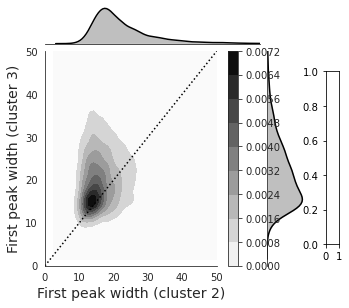

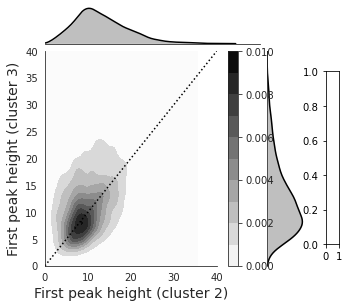

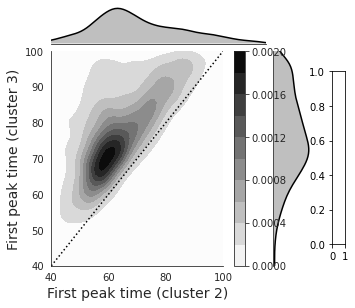

In [27]:

with sns.axes_style("white"):
    g=sns.jointplot(x=df_new[df_new['cluster_id']=='cluster2']['width'].values, 
                    y=df_new[df_new['cluster_id']=='cluster3']['width'].values, 
                    color='k', 
                    xlim=[0,50], ylim=[0,50],
                   dropna=True,
                    #marginal_kws=dict(bins=15),
                   kind='kde', 
                    cbar=True
                   #joint_kws=joint_kws
                   );
#plt.xlabel('Peak width of cluster 2', fontsize=15)
#plt.ylabel('Peak width of cluster 3', fontsize=15)
g.ax_joint.collections[0].set_alpha(0.3)
lims = [max(0, 0), min(50, 50)]
g.ax_joint.plot(lims, lims, ':k')
g.set_axis_labels('First peak width (cluster 2)', 'First peak width (cluster 3)', fontsize=14)

plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2) 
cbar_ax = g.fig.add_axes([.85, .25, .03, .4])
#plt.colorbar(cax=cbar_ax, )


with sns.axes_style("white"):
    g=sns.jointplot(x=df_new[df_new['cluster_id']=='cluster2']['height'].values, 
                    y=df_new[df_new['cluster_id']=='cluster3']['height'].values, 
                    color='k', 
                    xlim=[0,40], ylim=[0,40],
                   dropna=True,
                    #marginal_kws=dict(bins=20),
                   kind='kde', 
                    cbar=True
                   );
g.ax_joint.collections[0].set_alpha(0.3)
#plt.xlabel('Peak height of cluster 2', fontsize=15)
#plt.ylabel('Peak height of cluster 3', fontsize=15)
lims = [max(0, 0), min(40, 40)]
g.ax_joint.plot(lims, lims, ':k') 
g.set_axis_labels('First peak height (cluster 2)', 'First peak height (cluster 3)', fontsize=14)

plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2) 
cbar_ax = g.fig.add_axes([.85, .25, .03, .4])

joint_kws=dict(gridsize=30)
with sns.axes_style("white"):
    t2=df_new[df_new['cluster_id']=='cluster2']['time'].values
    t3=df_new[df_new['cluster_id']=='cluster3']['time'].values
    g=sns.jointplot(x=t2[np.where((t2<100) & (t3<100))[0]], 
                    y=t3[np.where((t2<100) & (t3<100))[0]], 
                    color='k', 
                    xlim=[40,100], ylim=[40,100],
                   dropna=True,
                    #marginal_kws=dict(bins=25),
                   kind='kde', 
                    cbar=True
                   #joint_kws=joint_kws
                   );
g.ax_joint.collections[0].set_alpha(0.2)
#plt.xlabel('TTP of cluster 2', fontsize=15)
#plt.ylabel('TTP of cluster 3', fontsize=15)
lims = [min(40, 40), max(100, 100)]
g.ax_joint.plot(lims, lims, ':k') 
g.set_axis_labels('First peak time (cluster 2)', 'First peak time (cluster 3)', fontsize=14)

plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2) 
cbar_ax = g.fig.add_axes([.85, .25, .03, .4])
#plt.colorbar(cax=cbar_ax, )



In [23]:
# statistics
from scipy.stats import ttest_ind
tmp1=df_new[df_new['cluster_id']=='cluster2']['width'].values
tmp2=df_new[df_new['cluster_id']=='cluster3']['width'].values
ttest_ind(tmp1[np.isnan(tmp1)!=1], tmp2[np.isnan(tmp2)!=1])

Ttest_indResult(statistic=-31.462134152887764, pvalue=3.334115643161372e-211)

In [24]:
len(df_new[df_new['cluster_id']=='cluster2']['width'].values)

8480

In [25]:
tmp1=df_new[df_new['cluster_id']=='cluster2']['height'].values
tmp2=df_new[df_new['cluster_id']=='cluster3']['height'].values
ttest_ind(tmp1[np.isnan(tmp1)!=1], tmp2[np.isnan(tmp2)!=1])


Ttest_indResult(statistic=-20.949045324155566, pvalue=3.1820531747286775e-96)

In [26]:
tmp1=df_new[df_new['cluster_id']=='cluster2']['time'].values
tmp2=df_new[df_new['cluster_id']=='cluster3']['time'].values
ttest_ind(tmp1[np.isnan(tmp1)!=1], tmp2[np.isnan(tmp2)!=1])


Ttest_indResult(statistic=-17.44940289226826, pvalue=1.3590124093462218e-67)

# plot example population psth

In [11]:
def plot_fill_between(tmp, time, color='blue'):
    # tmp: neuron*time
    mean = np.mean(tmp, axis=0)
    error = np.std(tmp, axis=0)/np.sqrt(tmp.shape[0])
    plt.plot(time, mean, color = color, alpha=0.9)
    plt.fill_between(time, mean-error, mean+error, color = color, alpha=0.3)


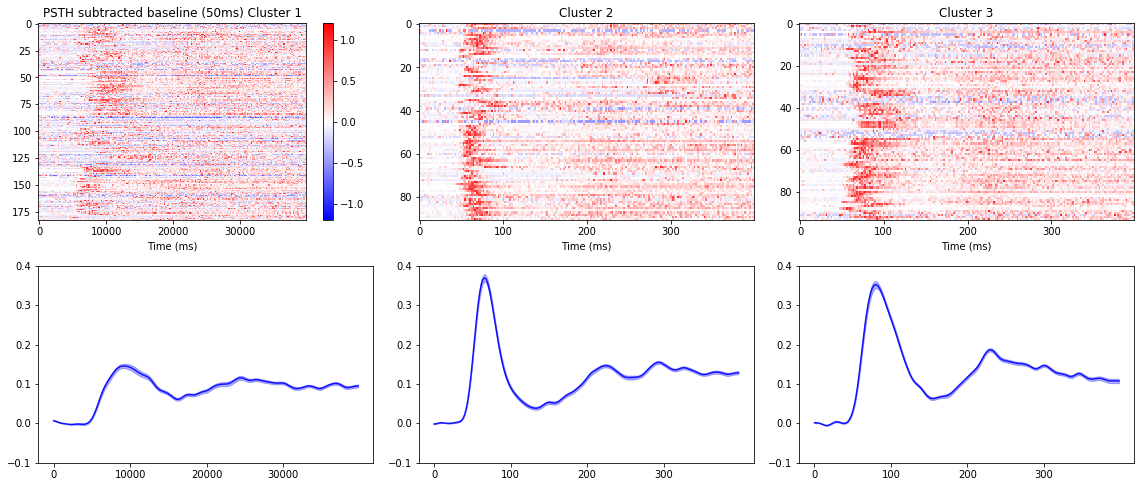

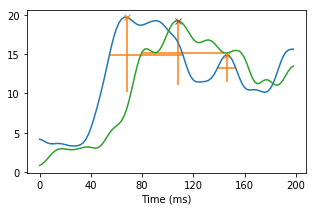

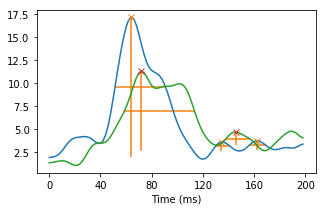

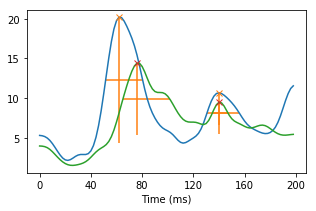

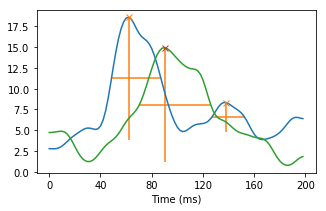

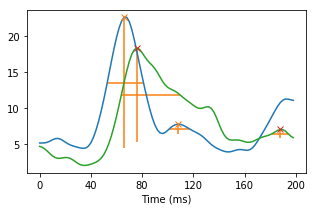

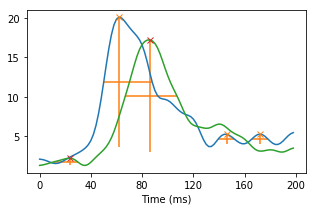

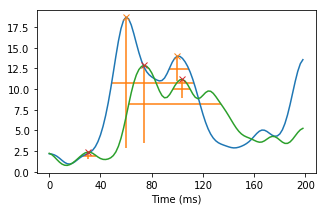

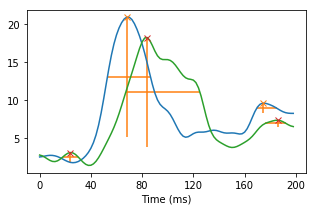

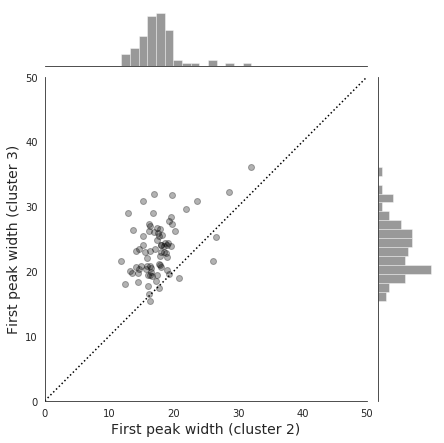

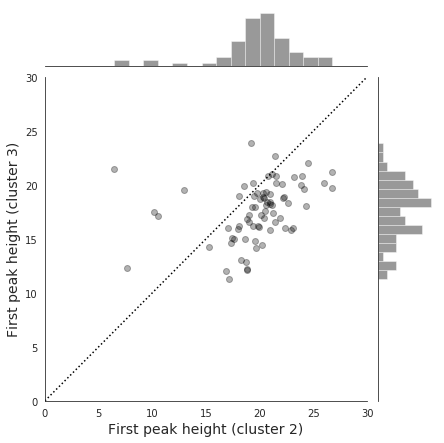

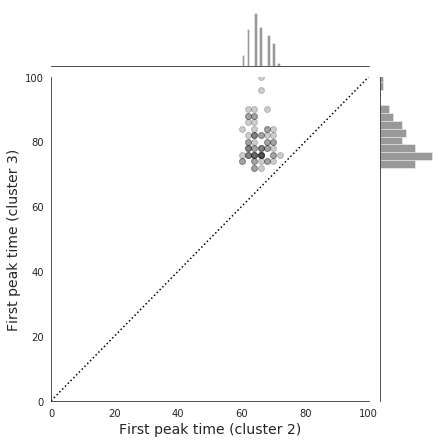

In [19]:
# select trials with number of spikes above threshold in a population
# bin size influence width detection parameter
PSTH_bintime=2
cmap_max=1.2

smooth=3


mouseID='412804'

# 1. load spikes
#basepath = '/Volumes/local1/work_allen/Ephys/mouse'+mouseID
basepath = '/Users/xiaoxuanj/work/work_allen/Ephys/mouse'+mouseID

# spikes for preferred condition
spikes_pref = np.load(basepath+'/psth_pref_trial.npy')
df_all = dl.data_loader(mouseID, datatype='units_cortex')[0]
assert spikes_pref.shape[0]==len(df_all)

# 2. select units CCG cluster and RF on screen
df=pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/meta_cluster/mouse'+mouseID+'_meta_cluster.csv', index_col=0)

select_idx = []
for idx, row in df_all.iterrows():
    probe_id=row['probe_id']
    unit_id=row['unit_id']
    if unit_id in df[df.probe_id==probe_id].unit_id.values:
        select_idx.append(idx)      

spikes_pref = spikes_pref[select_idx, :, :]
assert spikes_pref.shape[0]==len(df)

labels=df.cluster.values

# calculate PSTH for 1. all condition: spikes 2. preferred: spikes_pref
unit_psth, time = pu.get_PSTH_alldim(spikes_pref, PSTH_bintime=PSTH_bintime)
# convert to spk/sec
unit_psth = unit_psth/(PSTH_bintime/1000.)

unit_psth_mean=unit_psth.mean(1)
unit_psth_mean.shape

# scale to the same size
plt.figure(figsize=(16,10))
plt.subplot(331)
tmp = unit_psth_mean[np.where(labels==1)[0],:]
tmp_baseline=tmp[:,:400/PSTH_bintime]-np.tile(tmp[:,:30/PSTH_bintime].mean(1), (400/PSTH_bintime,1)).T
tmp_baseline_norm=tmp_baseline/np.tile(np.max(tmp_baseline, axis=1), (tmp_baseline.shape[1],1)).T
plt.imshow(tmp_baseline_norm,
           vmin=-cmap_max, vmax=cmap_max,
           cmap='bwr', 
           aspect='auto')

x_label=np.arange(0,400/PSTH_bintime,50)*400/PSTH_bintime
plt.xticks(range(0,400/PSTH_bintime,50), x_label)
plt.colorbar()
plt.title('PSTH subtracted baseline (50ms) Cluster 1')
plt.xlabel('Time (ms)')

plt.subplot(334)
ttmp = gaussian_filter(tmp_baseline_norm, 3)
plot_fill_between(ttmp, range(ttmp.shape[1]), color='blue')
#plt.errorbar(range(ttmp.shape[1]), ttmp.mean(0), ttmp.std(0)/np.sqrt(ttmp.shape[0]))
plt.xticks(range(0,400/PSTH_bintime,50), x_label)
plt.ylim([-0.1,0.4])

plt.subplot(332)
tmp = unit_psth_mean[np.where(labels==2)[0],:]
tmp_baseline=tmp[:,:400/PSTH_bintime]-np.tile(tmp[:,:30/PSTH_bintime].mean(1), (400/PSTH_bintime,1)).T
tmp_baseline_norm=tmp_baseline/np.tile(np.max(tmp_baseline, axis=1), (tmp_baseline.shape[1],1)).T
plt.imshow(tmp_baseline_norm,
           vmin=-cmap_max, vmax=cmap_max,
           cmap='bwr', 
           aspect='auto')
x_label=np.arange(0,400/PSTH_bintime,50)*PSTH_bintime
plt.xticks(range(0,400/PSTH_bintime,50), x_label)
plt.title('Cluster 2')
plt.xlabel('Time (ms)')

plt.subplot(335)
ttmp = gaussian_filter(tmp_baseline_norm, 3)
plot_fill_between(ttmp, range(ttmp.shape[1]), color='blue')
#plt.errorbar(range(ttmp.shape[1]), ttmp.mean(0), ttmp.std(0)/np.sqrt(ttmp.shape[0]))
plt.xticks(range(0,400/PSTH_bintime,50), x_label)
plt.ylim([-0.1,0.4])

plt.subplot(333)
tmp = unit_psth_mean[np.where(labels==3)[0],:]
tmp_baseline=tmp[:,:400/PSTH_bintime]-np.tile(tmp[:,:30/PSTH_bintime].mean(1), (400/PSTH_bintime,1)).T
tmp_baseline_norm=tmp_baseline/np.tile(np.max(tmp_baseline, axis=1), (tmp_baseline.shape[1],1)).T
plt.imshow(tmp_baseline_norm,
           vmin=-cmap_max, vmax=cmap_max,
           cmap='bwr', 
           aspect='auto') #len(np.where(labels==2)[0])/float(len(np.where(labels==3)[0]))
x_label=np.arange(0,400/PSTH_bintime,50)*PSTH_bintime
plt.xticks(range(0,400/PSTH_bintime,50), x_label)
plt.title('Cluster 3')
plt.xlabel('Time (ms)')

plt.subplot(336)
ttmp = gaussian_filter(tmp_baseline_norm, 3)
plot_fill_between(ttmp, range(ttmp.shape[1]), color='blue')
#plt.errorbar(range(ttmp.shape[1]), ttmp.mean(0), ttmp.std(0)/np.sqrt(ttmp.shape[0]))
plt.xticks(range(0,400/PSTH_bintime,50), x_label)
plt.ylim([-0.1,0.4])

plt.tight_layout()
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/PSTH/example_mouse'+mouseID+'_PSTH_baseline_subtracted_all_norm_consist.pdf')

unit_psth2 = unit_psth[np.where(labels==2)[0],:,:]
unit_psth3 = unit_psth[np.where(labels==3)[0],:,:]
n_trial=unit_psth2.shape[1]

W2=np.nan*np.ones(n_trial)
W3=np.nan*np.ones(n_trial)
H2=np.nan*np.ones(n_trial)
H3=np.nan*np.ones(n_trial)
T2=np.nan*np.ones(n_trial)
T3=np.nan*np.ones(n_trial)
R2=np.nan*np.ones(n_trial)
R3=np.nan*np.ones(n_trial)
for t in np.arange(n_trial):
    x2=gaussian_filter(unit_psth2[:,t,0:100].mean(0), smooth)
    peaks2, properties2=find_psth_peaks(x2, prominence=0.8, width=5)        
    x3=gaussian_filter(unit_psth3[:,t,0:100].mean(0), smooth)
    peaks3, properties3=find_psth_peaks(x3, prominence=0.8, width=5)
    if len(properties2["right_ips"]-properties2["left_ips"])>0:
        # select the peak with largest width and save
        idx = np.where((properties2["right_ips"]-properties2["left_ips"])==
                       max(properties2["right_ips"]-properties2["left_ips"]))[0]
        W2[t] = (properties2["right_ips"]-properties2["left_ips"])[idx]
        H2[t] = (x2[peaks2])[idx]
        T2[t] = peaks2[idx]*PSTH_bintime
        R2[t] = sum(unit_psth2[:,t,0:100].mean(0))
    if len(properties3["right_ips"]-properties3["left_ips"])>0:
        # select the peak with largest width and save
        idx = np.where((properties3["right_ips"]-properties3["left_ips"])==
                       max(properties3["right_ips"]-properties3["left_ips"]))[0]
        W3[t] = (properties3["right_ips"]-properties3["left_ips"])[idx]
        H3[t] = (x3[peaks3])[idx]
        T3[t]=peaks3[idx]*PSTH_bintime
        R3[t] = sum(unit_psth3[:,t,0:100].mean(0))

    #print(width2, width3)
    #print(height2, height3)

    if np.isnan(W2[t])!=1 and t%10==0:
        plt.figure(figsize=(5,3))
        plt.plot(x2)
        plt.plot(peaks2, x2[peaks2], "x")
        plt.vlines(x=peaks2, ymin=x2[peaks2] - properties2["prominences"],
                   ymax = x2[peaks2], color = "C1")
        plt.hlines(y=properties2["width_heights"], xmin=properties2["left_ips"],
                   xmax=properties2["right_ips"], color = "C1")


        plt.plot(x3)
        plt.plot(peaks3, x3[peaks3], "x")
        plt.vlines(x=peaks3, ymin=x3[peaks3] - properties3["prominences"],
                   ymax = x3[peaks3], color = "C1")
        plt.hlines(y=properties3["width_heights"], xmin=properties3["left_ips"],
                   xmax=properties3["right_ips"], color = "C1")
        plt.xticks(np.arange(0, 101, 20), np.arange(0, 101, 20)*PSTH_bintime)
        plt.xlabel('Time (ms)')
        #plt.ylim([0,20])

        #plt.plot(spikes_select3[n,t,10*PSTH_bintime:100*PSTH_bintime]*1000)
        #plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/func_connect/cosyne/example_population_first_peak_1.pdf')
        #print(W2[t], H2[t], T2[t], W3[t], H3[t], T3[t])
        #plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/PSTH/example_mouse'+mouseID+'_PSTH_population_trial'+str(t/10)+'.pdf')


with sns.axes_style("white"):
    g=sns.jointplot(x=W2, y=W3, color="k", xlim=[0,50], ylim=[0,50],
                   marginal_kws=dict(bins=15),);
#plt.xlabel('Peak width of cluster 2', fontsize=15)
#plt.ylabel('Peak width of cluster 3', fontsize=15)
g.ax_joint.collections[0].set_alpha(0.3)
lims = [max(0, 0), min(50, 50)]
g.ax_joint.plot(lims, lims, ':k')
g.set_axis_labels('First peak width (cluster 2)', 'First peak width (cluster 3)', fontsize=14)
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/PSTH/example_mouse'+mouseID+'_PSTH_population_trial_width.pdf')

#plt.title('Compactness of population response', fontsize=16)

with sns.axes_style("white"):
    g=sns.jointplot(x=H2, y=H3, color="k", xlim=[0,30], ylim=[0,30],
                   marginal_kws=dict(bins=15),);
g.ax_joint.collections[0].set_alpha(0.3)
#plt.xlabel('Peak height of cluster 2', fontsize=15)
#plt.ylabel('Peak height of cluster 3', fontsize=15)
lims = [max(0, 0), min(30, 30)]
g.ax_joint.plot(lims, lims, ':k') 
g.set_axis_labels('First peak height (cluster 2)', 'First peak height (cluster 3)', fontsize=14)
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/PSTH/example_mouse'+mouseID+'_PSTH_population_trial_height.pdf')

with sns.axes_style("white"):
    g=sns.jointplot(x=T2[np.where((T2<120) & (T3<150))[0]], y=T3[np.where((T2<120) & (T3<150))[0]],  
                    color="k", xlim=[0,100], ylim=[0,100],
                   marginal_kws=dict(bins=15),);
g.ax_joint.collections[0].set_alpha(0.2)
#plt.xlabel('TTP of cluster 2', fontsize=15)
#plt.ylabel('TTP of cluster 3', fontsize=15)
lims = [max(0, 0), min(100, 100)]
g.ax_joint.plot(lims, lims, ':k') 
g.set_axis_labels('First peak time (cluster 2)', 'First peak time (cluster 3)', fontsize=14)
#plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/PSTH/example_mouse'+mouseID+'_PSTH_population_trial_time.pdf')
